# DETECTING MUSIC INSTRUMENTS - IRMAS DATASET

## Notebook huấn luyện mô hình nhận dạng nhạc cụ (Segment-based CNN)

**Phương pháp:**
- **CNN Segment-based**: Deep Learning với Mel Spectrogram và Segment-based Training/Testing

**Dataset**: IRMAS - 11 loại nhạc cụ, ~6,705 file âm thanh

**Hướng dẫn:**
1. Runtime > Change runtime type > **GPU**
2. Chạy từng cell theo thứ tự
3. Điều chỉnh `DRIVE_PATH` phù hợp với vị trí dataset


In [1]:
# Cài đặt thư viện
!pip install librosa audioread soundfile tqdm -q

import os, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
import librosa, librosa.display, joblib, zipfile, shutil
from tqdm import tqdm
import warnings; warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.utils import to_categorical

print("TensorFlow:", tf.__version__)
print("GPU:", tf.config.list_physical_devices('GPU'))


TensorFlow: 2.19.0
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# THAY ĐỔI ĐƯỜNG DẪN NÀY
DRIVE_PATH = '/content/drive/MyDrive/IRMAS_Dataset'
WORK_DIR = '/content/IRMAS'
os.makedirs(WORK_DIR, exist_ok=True)

print(f"Drive path: {DRIVE_PATH}")
if os.path.exists(DRIVE_PATH):
    print("Các file:", os.listdir(DRIVE_PATH))
else:
    print(" Không tìm thấy thư mục!")


Mounted at /content/drive
Drive path: /content/drive/MyDrive/IRMAS_Dataset
Các file: ['IRMAS-TestingData-Part1.zip', 'IRMAS-TestingData-Part3.zip', 'IRMAS-TrainingData.zip', 'IRMAS-TestingData-Part2.zip', 'irmas_features.npz']


In [4]:
# Giải nén dataset
def extract_zip(zip_path, extract_to):
    if os.path.exists(zip_path):
        print(f"Đang giải nén: {os.path.basename(zip_path)}...")
        with zipfile.ZipFile(zip_path, 'r') as z: z.extractall(extract_to)
        print(f"✓ Hoàn thành")
    else:
        print(f" Không tìm thấy: {zip_path}")

extract_zip(os.path.join(DRIVE_PATH, 'IRMAS-TrainingData.zip'), WORK_DIR)
for part in ['Part1', 'Part2', 'Part3']:
    extract_zip(os.path.join(DRIVE_PATH, f'IRMAS-TestingData-{part}.zip'), WORK_DIR)

# Tìm thư mục Training
for p in [os.path.join(WORK_DIR, 'IRMAS-TrainingData'), os.path.join(WORK_DIR, 'IRMAS-TrainingData', 'TrainingData')]:
    if os.path.exists(p): TRAINING_PATH = p; break
print(f"\nTraining path: {TRAINING_PATH}")


Đang giải nén: IRMAS-TrainingData.zip...
✓ Hoàn thành
Đang giải nén: IRMAS-TestingData-Part1.zip...
✓ Hoàn thành
Đang giải nén: IRMAS-TestingData-Part2.zip...
✓ Hoàn thành
Đang giải nén: IRMAS-TestingData-Part3.zip...
✓ Hoàn thành

Training path: /content/IRMAS/IRMAS-TrainingData


In [ ]:
# Cấu hình
INSTRUMENT_MAP = {'cel': 'Cello', 'cla': 'Clarinet', 'flu': 'Flute', 'gac': 'Acoustic Guitar',
                  'gel': 'Electric Guitar', 'org': 'Organ', 'pia': 'Piano', 'sax': 'Saxophone',
                  'tru': 'Trumpet', 'vio': 'Violin', 'voi': 'Voice'}
SAMPLE_RATE, DURATION, N_MELS, N_MFCC, HOP_LENGTH, N_FFT = 22050, 3.0, 128, 40, 512, 2048
RANDOM_STATE, TEST_SIZE = 42, 0.2

def load_audio(file_path):
    try:
        y, _ = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)
        target = int(SAMPLE_RATE * DURATION)
        return np.pad(y, (0, max(0, target - len(y))))[:target]
    except: return None



def extract_mel_spectrogram(y):
    return librosa.power_to_db(librosa.feature.melspectrogram(y=y, sr=SAMPLE_RATE, n_mels=N_MELS, n_fft=N_FFT, hop_length=HOP_LENGTH), ref=np.max)

print("✓ Cấu hình hoàn tất!")


✓ Cấu hình hoàn tất!


In [6]:
# Load dữ liệu
file_paths, labels = [], []
instruments = [d for d in os.listdir(TRAINING_PATH) if os.path.isdir(os.path.join(TRAINING_PATH, d))]
for inst in sorted(instruments):
    files = [f for f in os.listdir(os.path.join(TRAINING_PATH, inst)) if f.endswith('.wav')]
    file_paths.extend([os.path.join(TRAINING_PATH, inst, f) for f in files])
    labels.extend([inst] * len(files))
    print(f"  {inst}: {len(files)} files")
print(f"\nTổng: {len(file_paths)} files")


  cel: 388 files
  cla: 505 files
  flu: 451 files
  gac: 637 files
  gel: 760 files
  org: 682 files
  pia: 721 files
  sax: 626 files
  tru: 577 files
  vio: 580 files
  voi: 778 files

Tổng: 6705 files


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Trích xuất đặc trưng mel spectrogram
mel_specs, valid_labels = [], []
for path, label in tqdm(zip(file_paths, labels), total=len(file_paths)):
    y = load_audio(path)
    if y is None: continue
    try:
        mel_specs.append(extract_mel_spectrogram(y))
        valid_labels.append(label)
    except: continue

features = {'mel_spectrogram': np.array(mel_specs), 'labels': valid_labels}
print(f"\nMel Spec: {features['mel_spectrogram'].shape}")

# Lưu features
np.savez_compressed('/content/irmas_features.npz', **features)
print("Đã lưu features")


100%|██████████| 6705/6705 [01:55<00:00, 57.88it/s]



Mel Spec: (6705, 128, 130)
✓ Đã lưu features


---
# CNN VỚI SEGMENT-BASED TRAINING/TESTING

## Ý tưởng:
- **Training**: Mỗi file audio 3s → cắt thành 3-4 segments ngẫu nhiên (2.0s mỗi segment) → tăng data ×3-4
- **Testing**: Sliding window với overlap 50% → Predict từng segment → **Weighted Average** (segment có confidence cao được ưu tiên) → Quyết định cuối cùng

## Lợi ích:
-  Tăng lượng data training đáng kể (×3-4)
-  Segment dài hơn (2.0s) → Capture tốt hơn nhạc cụ sustain (organ, violin)
-  Model học được nhiều patterns đa dạng hơn  
-  Prediction robust hơn nhờ aggregation
-  Phù hợp cho dataset nhỏ như IRMAS (~6,705 files)

## Chiến lược Segment:
- **Training**: Random segments với overlap → Tăng diversity, giảm overfitting
- **Testing**: Sliding window với overlap 50% → Cover toàn bộ audio, ensemble theo thời gian

## Lưu ý quan trọng:
- Chia train/test ở cấp độ FILE trước (tránh data leakage)
- Sau đó mới cắt segments
- Với 2.0s segments từ 3s audio: có thể tạo 3-4 segments với overlap khi random
---


In [ ]:
# ============================================================
# CẤU HÌNH SEGMENT-BASED TRAINING
# ============================================================

# Segment parameters
SEGMENT_DURATION = 2.0  # Độ dài mỗi segment (giây)
#  Lưu ý: 2.0s segments tốt hơn cho nhạc cụ sustain (organ, violin)
#  Với 3s audio và 2.0s segment: có thể tạo 3-4 segments với overlap khi random
SEGMENT_SAMPLES = int(SAMPLE_RATE * SEGMENT_DURATION)  # Số samples mỗi segment
NUM_SEGMENTS_TRAIN = 6  # Số segments random cho mỗi file khi train
SEGMENT_OVERLAP = 0.5  # Overlap ratio cho sliding window khi test (50%)

# Mel spectrogram cho segment
N_MELS_SEG = 128
HOP_LENGTH_SEG = 512
N_FFT_SEG = 2048

print("="*60)
print("CẤU HÌNH SEGMENT-BASED")
print(f"  Segment duration: {SEGMENT_DURATION}s")
print(f"  Segment samples: {SEGMENT_SAMPLES}")
print(f"  Segments per file (train): {NUM_SEGMENTS_TRAIN}")
print(f"  Overlap ratio (test): {SEGMENT_OVERLAP}")
print(f"  Expected mel shape: ({N_MELS_SEG}, {int(SEGMENT_SAMPLES / HOP_LENGTH_SEG) + 1})")
print(f"  Training: 3s → random {NUM_SEGMENTS_TRAIN} segments × {SEGMENT_DURATION}s → Data ×{NUM_SEGMENTS_TRAIN}")
print("="*60)


CẤU HÌNH SEGMENT-BASED
  Segment duration: 2.0s
  Segment samples: 44100
  Segments per file (train): 6
  Overlap ratio (test): 0.5
  Expected mel shape: (128, 87)

 Chiến lược Segment:
    Training: 3s → random 6 segments × 2.0s → Data ×6
    Testing: Sliding window (overlap 50%) → Average softmax
    Segment dài hơn → Tốt cho nhạc cụ sustain (organ, violin)
    Phù hợp cho dataset nhỏ như IRMAS (~6,705 files)


In [ ]:
# HÀM EXTRACT SEGMENTS TỪ AUDIO
def load_full_audio(file_path, sr=SAMPLE_RATE):
    # Load toàn bộ file audio
    try:
        y, _ = librosa.load(file_path, sr=sr)
        return y
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None

def extract_random_segments(y, num_segments=NUM_SEGMENTS_TRAIN, segment_samples=SEGMENT_SAMPLES):
    # Cắt num_segments segments ngẫu nhiên từ audio signal.
    # Dùng cho TRAINING.
    segments = []
    audio_length = len(y)

    if audio_length < segment_samples:
        # Pad nếu audio quá ngắn
        y = np.pad(y, (0, segment_samples - audio_length))
        audio_length = len(y)

    max_start = audio_length - segment_samples

    for _ in range(num_segments):
        if max_start > 0:
            start = np.random.randint(0, max_start)
        else:
            start = 0
        segment = y[start:start + segment_samples]
        segments.append(segment)

    return segments

def extract_sliding_segments(y, segment_samples=SEGMENT_SAMPLES, overlap=SEGMENT_OVERLAP):
    # Cắt segments với sliding window và overlap.
    # Dùng cho TESTING để đảm bảo cover toàn bộ audio.
    segments = []
    audio_length = len(y)

    if audio_length < segment_samples:
        # Pad nếu audio quá ngắn
        y = np.pad(y, (0, segment_samples - audio_length))
        audio_length = len(y)

    hop = int(segment_samples * (1 - overlap))
    start = 0

    while start + segment_samples <= audio_length:
        segment = y[start:start + segment_samples]
        segments.append(segment)
        start += hop

    # Thêm segment cuối nếu còn dư
    if start < audio_length:
        segment = y[-segment_samples:]  # Lấy segment_samples cuối
        if len(segments) == 0 or not np.array_equal(segment, segments[-1]):
            segments.append(segment)

    return segments

def segment_to_mel(segment, sr=SAMPLE_RATE, n_mels=N_MELS_SEG, n_fft=N_FFT_SEG, hop_length=HOP_LENGTH_SEG):
    # Chuyển segment thành mel spectrogram
    mel_spec = librosa.feature.melspectrogram(y=segment, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec_db

print("Đã định nghĩa các hàm extract segments")


✓ Đã định nghĩa các hàm extract segments


In [ ]:
# CHIA TRAIN/VAL/TEST Ở CẤP ĐỘ FILE

# Sử dụng lại file_paths và labels đã load từ trước
print(f"Tổng số files: {len(file_paths)}")

# Chia train/test trước (ở cấp độ FILE)
train_files, test_files, train_labels, test_labels = train_test_split(
    file_paths, labels,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=labels
)

# Chia train thành train/val (85% train, 15% val)
train_files, val_files, train_labels, val_labels = train_test_split(
    train_files, train_labels,
    test_size=0.15,
    random_state=RANDOM_STATE,
    stratify=train_labels
)

print(f"\n{'='*60}")
print(f"  Train files: {len(train_files)}")
print(f"  Val files:   {len(val_files)}")
print(f"  Test files:  {len(test_files)}")
print(f"{'='*60}")


Tổng số files: 6705

CHIA DỮ LIỆU Ở CẤP ĐỘ FILE (Tránh Data Leakage)
  Train files: 4559
  Val files:   805
  Test files:  1341


In [ ]:
# TRÍCH XUẤT SEGMENTS VÀ TẠO DATASET
def extract_segments_from_files(file_list, label_list, mode='train', num_segments=NUM_SEGMENTS_TRAIN):
    # Trích xuất segments từ list files.
    # mode='train': random segments
    # mode='val' hoặc 'test': sliding window segments
    all_segments = []
    all_labels = []
    file_indices = []  # Để track segment thuộc file nào

    for idx, (file_path, label) in enumerate(tqdm(zip(file_list, label_list), total=len(file_list), desc=f"Extracting {mode}")):
        y = load_full_audio(file_path)
        if y is None:
            continue

        if mode == 'train':
            segments = extract_random_segments(y, num_segments=num_segments)
        else:
            segments = extract_sliding_segments(y)

        for seg in segments:
            mel = segment_to_mel(seg)
            all_segments.append(mel)
            all_labels.append(label)
            file_indices.append(idx)

    return np.array(all_segments), all_labels, file_indices

# Trích xuất segments cho TRAIN
print("TRÍCH XUẤT SEGMENTS")
X_train_seg, y_train_seg, _ = extract_segments_from_files(train_files, train_labels, mode='train', num_segments=NUM_SEGMENTS_TRAIN)
print(f"Train segments: {X_train_seg.shape}")

# Trích xuất segments cho VAL (dùng sliding window để consistent)
X_val_seg, y_val_seg, val_file_indices = extract_segments_from_files(val_files, val_labels, mode='val')
print(f"Val segments: {X_val_seg.shape}")

# Trích xuất segments cho TEST
X_test_seg, y_test_seg, test_file_indices = extract_segments_from_files(test_files, test_labels, mode='test')
print(f"Test segments: {X_test_seg.shape}")

print(f"\n{'='*60}")
print(f"  Train: {len(train_files)} files → {X_train_seg.shape[0]} segments (x{X_train_seg.shape[0]/len(train_files):.1f})")
print(f"  Val:   {len(val_files)} files → {X_val_seg.shape[0]} segments")
print(f"  Test:  {len(test_files)} files → {X_test_seg.shape[0]} segments")
print(f"{'='*60}")



TRÍCH XUẤT SEGMENTS


Extracting train: 100%|██████████| 4559/4559 [03:15<00:00, 23.33it/s]


✓ Train segments: (27354, 128, 87)


Extracting val: 100%|██████████| 805/805 [00:15<00:00, 51.90it/s]


✓ Val segments: (1610, 128, 87)


Extracting test: 100%|██████████| 1341/1341 [00:25<00:00, 51.94it/s]


✓ Test segments: (2682, 128, 87)

TỔNG KẾT:
  Train: 4559 files → 27354 segments (x6.0)
  Val:   805 files → 1610 segments
  Test:  1341 files → 2682 segments


In [ ]:
# CHUẨN BỊ DATA CHO TRAINING
# Encode labels
label_encoder_seg = LabelEncoder()
label_encoder_seg.fit(labels)  # Fit trên toàn bộ labels để đảm bảo consistent

y_train_encoded = label_encoder_seg.transform(y_train_seg)
y_val_encoded = label_encoder_seg.transform(y_val_seg)
y_test_encoded = label_encoder_seg.transform(y_test_seg)

n_classes_seg = len(label_encoder_seg.classes_)

# Thêm channel dimension cho CNN
X_train_seg = X_train_seg[..., np.newaxis]
X_val_seg = X_val_seg[..., np.newaxis]
X_test_seg = X_test_seg[..., np.newaxis]

# Convert to categorical
y_train_cat_seg = to_categorical(y_train_encoded, n_classes_seg)
y_val_cat_seg = to_categorical(y_val_encoded, n_classes_seg)
y_test_cat_seg = to_categorical(y_test_encoded, n_classes_seg)

# Tính Class Weights
from sklearn.utils.class_weight import compute_class_weight
class_weights_seg = compute_class_weight('balanced', classes=np.unique(y_train_encoded), y=y_train_encoded)
class_weight_dict_seg = {i: w for i, w in enumerate(class_weights_seg)}

print("="*60)
print("DATA")
print(f"  X_train shape: {X_train_seg.shape}")
print(f"  X_val shape:   {X_val_seg.shape}")
print(f"  X_test shape:  {X_test_seg.shape}")
print(f"  Số classes:    {n_classes_seg}")
print(f"\nLabel mapping:")
for i, l in enumerate(label_encoder_seg.classes_):
    print(f"  {i}: {l} ({INSTRUMENT_MAP.get(l, l)})")
print("="*60)


DATA ĐÃ CHUẨN BỊ
  X_train shape: (27354, 128, 87, 1)
  X_val shape:   (1610, 128, 87, 1)
  X_test shape:  (2682, 128, 87, 1)
  Số classes:    11

Label mapping:
  0: cel (Cello)
  1: cla (Clarinet)
  2: flu (Flute)
  3: gac (Acoustic Guitar)
  4: gel (Electric Guitar)
  5: org (Organ)
  6: pia (Piano)
  7: sax (Saxophone)
  8: tru (Trumpet)
  9: vio (Violin)
  10: voi (Voice)


In [ ]:
# DATA GENERATOR VỚI SPECAUGMENT
class SegmentDataGenerator(keras.utils.Sequence):
    # Data Generator với SpecAugment và Mixup cho segment-based training.
    def __init__(self, x, y, batch_size=32, augment=True, mixup=True, shuffle=True):
        self.x = x
        self.y = y
        self.batch_size = batch_size
        self.augment = augment
        self.mixup = mixup
        self.shuffle = shuffle
        self.indices = np.arange(len(x))
        if shuffle:
            np.random.shuffle(self.indices)

    def __len__(self):
        return int(np.ceil(len(self.x) / self.batch_size))

    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        x_batch = self.x[batch_indices].copy()
        y_batch = self.y[batch_indices].copy()

        if self.augment:
            x_batch = self._spec_augment(x_batch)

        if self.mixup and np.random.random() > 0.5:
            x_batch, y_batch = self._mixup(x_batch, y_batch)

        return x_batch, y_batch

    def _spec_augment(self, batch, time_mask_param=20, freq_mask_param=15, num_masks=2):
        # SpecAugment: Time và Frequency Masking
        augmented = batch.copy()
        _, time_steps, freq_bins, _ = augmented.shape

        for i in range(len(augmented)):
            for _ in range(num_masks):
                # Time masking
                t = np.random.randint(0, time_mask_param)
                t0 = np.random.randint(0, max(1, time_steps - t))
                augmented[i, t0:t0+t, :, :] = 0

                # Frequency masking
                f = np.random.randint(0, freq_mask_param)
                f0 = np.random.randint(0, max(1, freq_bins - f))
                augmented[i, :, f0:f0+f, :] = 0

        return augmented

    def _mixup(self, x, y, alpha=0.2):
        # Mixup augmentation
        batch_size = len(x)
        indices = np.random.permutation(batch_size)
        lam = np.random.beta(alpha, alpha)
        x_mixed = lam * x + (1 - lam) * x[indices]
        y_mixed = lam * y + (1 - lam) * y[indices]
        return x_mixed, y_mixed

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

# Tạo generators
BATCH_SIZE_SEG = 64  # Batch size cho segment-based training
train_gen_seg = SegmentDataGenerator(X_train_seg, y_train_cat_seg, batch_size=BATCH_SIZE_SEG, augment=True, mixup=True)
val_gen_seg = SegmentDataGenerator(X_val_seg, y_val_cat_seg, batch_size=BATCH_SIZE_SEG, augment=False, mixup=False, shuffle=False)

print("Đã tạo Data Generators với SpecAugment + Mixup")
print(f"  Train batches: {len(train_gen_seg)}")
print(f"  Val batches: {len(val_gen_seg)}")


✓ Đã tạo Data Generators với SpecAugment + Mixup
  Train batches: 428
  Val batches: 26


In [ ]:
# BUILD CNN MODEL CHO SEGMENT-BASED TRAINING
def build_segment_cnn(input_shape, n_classes):
    # CNN model tối ưu cho segment-based training.
    # Sử dụng L2 regularization và Dropout để tránh overfitting.
    reg = keras.regularizers.l2(0.001)

    model = models.Sequential([
        # Block 1
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=reg, input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=reg),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Block 2
        layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=reg),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=reg),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Block 3
        layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=reg),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=reg),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),

        # Block 4
        layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=reg),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=reg),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),

        # Dense layers
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu', kernel_regularizer=reg),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu', kernel_regularizer=reg),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(n_classes, activation='softmax')
    ])

    return model

# FOCAL LOSS - Tập trung vào các class khó phân biệt
def focal_loss(gamma=2.0):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = keras.backend.epsilon()
        y_pred = keras.backend.clip(y_pred, epsilon, 1.0 - epsilon)

        # Cross entropy
        ce = -y_true * keras.backend.log(y_pred)

        # p_t: probability của true class
        # p_t cao (dễ predict) → weight thấp → ít chú ý
        # p_t thấp (khó predict) → weight cao → chú ý nhiều
        p_t = keras.backend.sum(y_true * y_pred, axis=-1, keepdims=True)
        focal_weight = keras.backend.pow((1 - p_t), gamma)

        loss = focal_weight * ce
        return keras.backend.mean(loss)

    return focal_loss_fixed

# Build model
segment_cnn = build_segment_cnn(X_train_seg.shape[1:], n_classes_seg)

# Compile với Focal Loss + AdamW optimizer
segment_cnn.compile(
    optimizer=keras.optimizers.AdamW(learning_rate=0.001, weight_decay=0.01),
    loss=focal_loss(gamma=2.0),  # Focal Loss với gamma=2.0
    metrics=['accuracy']
)

segment_cnn.summary()
print(f"\nModel được build với input shape: {X_train_seg.shape[1:]}")


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 87, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 87, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 87, 32)    │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 87, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 43, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 43, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 43, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 43, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 43, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 43, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 21, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 21, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 21, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 21, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 21, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 10, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 16, 10, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 10, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,444,331 (5.51 MB)

 Trainable params: 1,440,875 (5.50 MB)

 Non-trainable params: 3,456 (13.50 KB)


✓ Model được build với input shape: (128, 87, 1)


In [ ]:
# TRAINING CNN VỚI SEGMENT DATA
# Callbacks
segment_callbacks = [
    callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=15,
        restore_best_weights=True,
        verbose=1,
        mode='max'
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=7,
        min_lr=1e-7,
        verbose=1
    ),
    callbacks.ModelCheckpoint(
        '/content/best_segment_cnn.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1,
        mode='max'
    )
]

# Training
EPOCHS_SEG = 100  # epochs

print("BẮT ĐẦU TRAINING CNN VỚI SEGMENT-BASED DATA")
print(f"  Training samples: {len(X_train_seg)}")
print(f"  Validation samples: {len(X_val_seg)}")
print(f"  Epochs: {EPOCHS_SEG}")
print(f"  Batch size: 64")

history_seg = segment_cnn.fit(
    train_gen_seg,
    validation_data=(X_val_seg, y_val_cat_seg),
    epochs=EPOCHS_SEG,
    callbacks=segment_callbacks,
    class_weight=class_weight_dict_seg,
    verbose=1
)

print("\nTraining hoàn tất!")


BẮT ĐẦU TRAINING CNN VỚI SEGMENT-BASED DATA
  Training samples: 27354
  Validation samples: 1610
  Epochs: 100
  Batch size: 64

Epoch 1/100
426/428 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.1593 - loss: 1.3251
Epoch 1: val_accuracy improved from -inf to 0.15031, saving model to /content/best_segment_cnn.keras
428/428 ━━━━━━━━━━━━━━━━━━━━ 55s 66ms/step - accuracy: 0.1596 - loss: 1.3226 - val_accuracy: 0.1503 - val_loss: 0.4586 - learning_rate: 0.0010
Epoch 2/100
425/428 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2710 - loss: 0.3433
Epoch 2: val_accuracy improved from 0.15031 to 0.22360, saving model to /content/best_segment_cnn.keras
428/428 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.2712 - loss: 0.3428 - val_accuracy: 0.2236 - val_loss: 0.2444 - learning_rate: 0.0010
Epoch 3/100
426/428 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3405 - loss: 0.1984
Epoch 3: val_accuracy did not improve from 0.22360
428/428 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.3406 - los

In [ ]:
# ĐÁNH GIÁ VỚI SEGMENT AGGREGATION
def evaluate_with_aggregation(model, test_files, test_labels, label_encoder):
    """
    Đánh giá model với segment aggregation:
    1. Cắt mỗi file test thành nhiều segments (sliding window)
    2. Predict từng segment
    3. Weighted average của tất cả segments (segment có confidence cao được ưu tiên)
    4. Quyết định cuối cùng = argmax của weighted average probabilities
    """
    file_predictions = []
    file_true_labels = []
    file_confidences = []

    print("Đang đánh giá với segment aggregation...")

    for file_path, label in tqdm(zip(test_files, test_labels), total=len(test_files)):
        # Load audio
        y = load_full_audio(file_path)
        if y is None:
            continue

        # Extract segments (sliding window)
        segments = extract_sliding_segments(y)

        # Convert segments to mel spectrograms
        mel_segments = []
        for seg in segments:
            mel = segment_to_mel(seg)
            mel_segments.append(mel)

        mel_segments = np.array(mel_segments)[..., np.newaxis]

        # Predict all segments
        segment_probs = model.predict(mel_segments, verbose=0)

        # Weighted average: segment có confidence cao hơn được ưu tiên
        segment_weights = np.max(segment_probs, axis=1)  # Confidence của mỗi segment
        segment_weights = segment_weights / (segment_weights.sum() + 1e-10)  # Normalize
        avg_probs = np.average(segment_probs, axis=0, weights=segment_weights)

        # Final prediction
        final_pred = np.argmax(avg_probs)
        confidence = avg_probs[final_pred]

        file_predictions.append(final_pred)
        file_true_labels.append(label_encoder.transform([label])[0])
        file_confidences.append(confidence)

    return np.array(file_predictions), np.array(file_true_labels), np.array(file_confidences)

# Load best model
# Để tải lại mô hình với hàm mất mát tùy chỉnh (focal_loss),
# chúng ta cần cung cấp hàm đó trong custom_objects.
# Đảm bảo rằng hàm focal_loss (đã định nghĩa ở cell trước) có sẵn trong scope này.
segment_cnn_best = keras.models.load_model(
    '/content/best_segment_cnn.keras',
    custom_objects={'focal_loss_fixed': focal_loss(gamma=2.0)} # Cung cấp hàm focal_loss
)

# Evaluate với aggregation
y_pred_agg, y_true_agg, confidences = evaluate_with_aggregation(
    segment_cnn_best, test_files, test_labels, label_encoder_seg
)

# Accuracy với aggregation
acc_segment_agg = accuracy_score(y_true_agg, y_pred_agg)

print(f"\n{'='*60}")
print(f"KẾT QUẢ SEGMENT-BASED CNN VỚI AGGREGATION")
print(f"{'='*60}")
print(f"  Accuracy: {acc_segment_agg*100:.2f}%")
print(f"  Average Confidence: {np.mean(confidences)*100:.2f}%")
print(f"{'='*60}")


Đang đánh giá với segment aggregation...


100%|██████████| 1341/1341 [02:27<00:00,  9.10it/s]


KẾT QUẢ SEGMENT-BASED CNN VỚI AGGREGATION
  Accuracy: 84.64%
  Average Confidence: 80.95%



CLASSIFICATION REPORT - SEGMENT-BASED CNN (Training Test Set)
                 precision    recall  f1-score   support

          Cello       0.68      0.91      0.78        78
       Clarinet       0.79      0.80      0.79       101
          Flute       0.78      0.78      0.78        90
Acoustic Guitar       0.87      0.91      0.89       127
Electric Guitar       0.82      0.85      0.83       152
          Organ       0.85      0.97      0.90       136
          Piano       0.92      0.91      0.92       144
      Saxophone       0.77      0.70      0.73       125
        Trumpet       0.95      0.85      0.90       116
         Violin       0.89      0.61      0.72       116
          Voice       0.94      0.95      0.94       156

       accuracy                           0.85      1341
      macro avg       0.84      0.84      0.84      1341
   weighted avg       0.85      0.85      0.84      1341



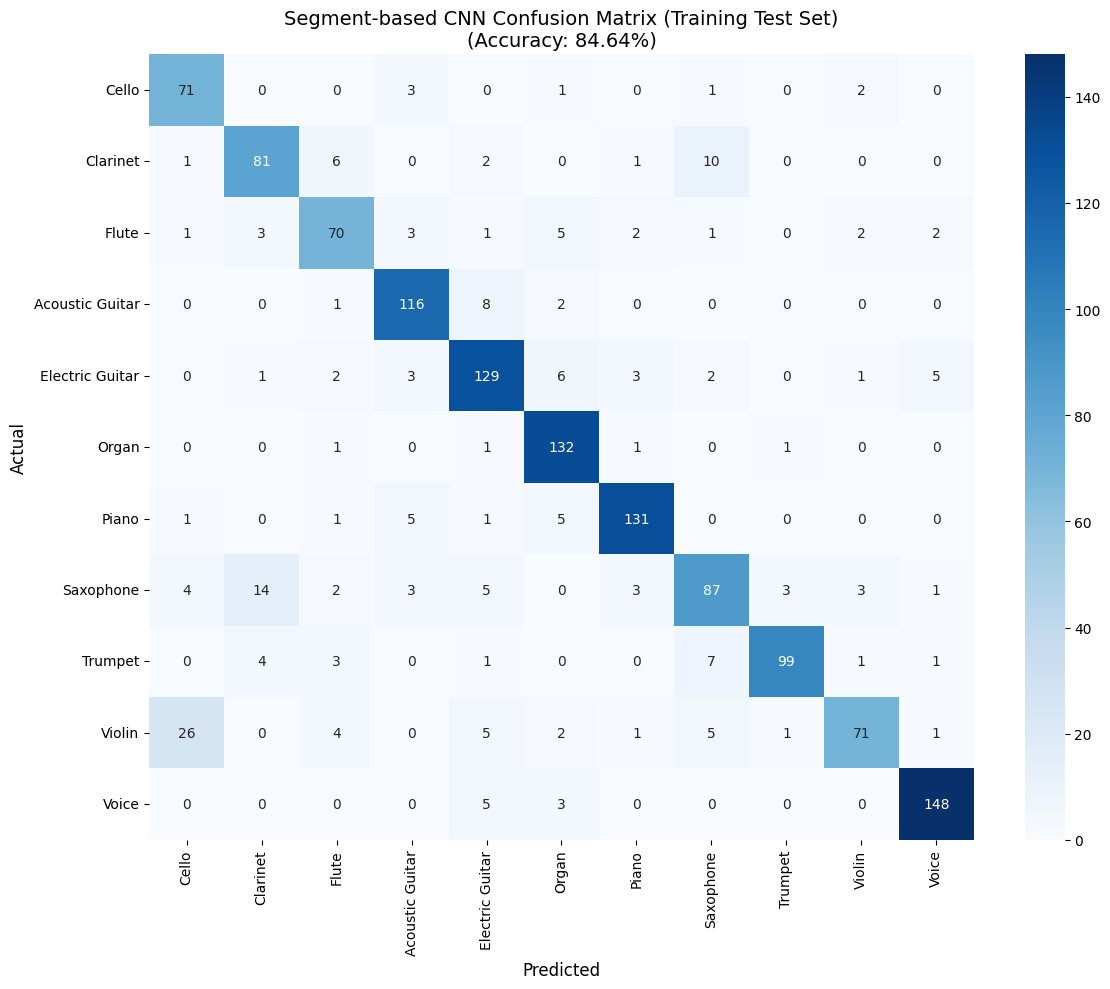

In [19]:
# CLASSIFICATION REPORT VÀ CONFUSION MATRIX CHO TRAINING TEST SET
# Classification Report
print("\n" + "="*60)
print("CLASSIFICATION REPORT - SEGMENT-BASED CNN (Training Test Set)")
print("="*60)
print(classification_report(
    y_true_agg, y_pred_agg,
    target_names=[INSTRUMENT_MAP.get(x, x) for x in label_encoder_seg.classes_]
))

# Confusion Matrix
plt.figure(figsize=(12, 10))
cm_train_test = confusion_matrix(y_true_agg, y_pred_agg)
sns.heatmap(
    cm_train_test, annot=True, fmt='d', cmap='Blues',
    xticklabels=[INSTRUMENT_MAP.get(x, x) for x in label_encoder_seg.classes_],
    yticklabels=[INSTRUMENT_MAP.get(x, x) for x in label_encoder_seg.classes_]
)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title(f'Segment-based CNN Confusion Matrix (Training Test Set)\n(Accuracy: {acc_segment_agg*100:.2f}%)', fontsize=14)
plt.tight_layout()
plt.show()


In [ ]:
# LƯU MODEL SEGMENT-BASED CNN
# Đảm bảo SAVE_PATH đã được định nghĩa
if 'SAVE_PATH' not in locals():
    SAVE_PATH = '/content/drive/MyDrive/IRMAS_Models'
    os.makedirs(SAVE_PATH, exist_ok=True)

# Copy model lên Google Drive
shutil.copy('/content/best_segment_cnn.keras', f'{SAVE_PATH}/best_segment_cnn.keras')

# Lưu label encoder
joblib.dump(label_encoder_seg, f'{SAVE_PATH}/label_encoder_seg.joblib')

# Lưu config
segment_config = {
    'segment_duration': SEGMENT_DURATION,
    'segment_samples': SEGMENT_SAMPLES,
    'num_segments_train': NUM_SEGMENTS_TRAIN,
    'segment_overlap': SEGMENT_OVERLAP,
    'n_mels': N_MELS_SEG,
    'hop_length': HOP_LENGTH_SEG,
    'n_fft': N_FFT_SEG,
    'sample_rate': SAMPLE_RATE
}
joblib.dump(segment_config, f'{SAVE_PATH}/segment_config.joblib')

print(f"Đã lưu Segment-based CNN model và config vào {SAVE_PATH}")
print("\nCác file đã lưu:")
for f in os.listdir(SAVE_PATH):
    if 'segment' in f.lower() or 'cnn' in f.lower():
        size_mb = os.path.getsize(os.path.join(SAVE_PATH, f)) / (1024*1024)
        print(f"  - {f}: {size_mb:.2f} MB")


✓ Đã lưu Segment-based CNN model và config vào /content/drive/MyDrive/IRMAS_Models

Các file đã lưu:
  - best_segment_cnn.keras: 16.65 MB
  - segment_config.joblib: 0.00 MB


---
# ĐÁNH GIÁ MODEL TRÊN TESTING DATA REALTIME
---


In [ ]:
# GIẢI NÉN VÀ LOAD TESTING DATA
print("GIẢI NÉN TESTING DATA")

for part in ['Part1', 'Part2', 'Part3']:
    zip_path = os.path.join(DRIVE_PATH, f'IRMAS-TestingData-{part}.zip')
    extract_zip(zip_path, WORK_DIR)

# Tìm và load tất cả file test
TESTING_DATA_PARTS = ['IRMAS-TestingData-Part1', 'IRMAS-TestingData-Part2', 'IRMAS-TestingData-Part3']

def get_actual_labels(txt_path):
    """Đọc labels từ file .txt"""
    if os.path.exists(txt_path):
        with open(txt_path, 'r') as f:
            labels = [line.strip() for line in f.readlines() if line.strip()]
            return labels if labels else []
    return []

# Collect test file paths và labels
testing_file_paths = []
testing_labels_list = []  # List of lists (mỗi file có thể có nhiều labels)

print("\nĐang tìm các file test...")
for part_dir in TESTING_DATA_PARTS:
    part_path = os.path.join(WORK_DIR, part_dir)
    if os.path.exists(part_path):
        for root, _, files in os.walk(part_path):
            for file in files:
                if file.endswith('.wav'):
                    wav_path = os.path.join(root, file)
                    txt_path = wav_path.replace('.wav', '.txt')
                    labels = get_actual_labels(txt_path)

                    if labels:  # Chỉ thêm nếu có labels
                        testing_file_paths.append(wav_path)
                        testing_labels_list.append(labels)

print(f"✓ Tìm thấy {len(testing_file_paths)} file test có labels")

# Thống kê labels
all_test_labels = []
for labels in testing_labels_list:
    all_test_labels.extend(labels)

from collections import Counter
label_counts = Counter(all_test_labels)
print(f"\nThống kê labels trong TestingData:")
for label, count in sorted(label_counts.items()):
    instrument = INSTRUMENT_MAP.get(label, label)
    print(f"  {label} ({instrument}): {count} files")


GIẢI NÉN TESTING DATA
Đang giải nén: IRMAS-TestingData-Part1.zip...
✓ Hoàn thành
Đang giải nén: IRMAS-TestingData-Part2.zip...
✓ Hoàn thành
Đang giải nén: IRMAS-TestingData-Part3.zip...
✓ Hoàn thành

Đang tìm các file test...
✓ Tìm thấy 2874 file test có labels

Thống kê labels trong TestingData:
  cel (Cello): 111 files
  cla (Clarinet): 62 files
  flu (Flute): 163 files
  gac (Acoustic Guitar): 535 files
  gel (Electric Guitar): 942 files
  org (Organ): 361 files
  pia (Piano): 995 files
  sax (Saxophone): 326 files
  tru (Trumpet): 167 files
  vio (Violin): 211 files
  voi (Voice): 1044 files


In [ ]:
# ĐÁNH GIÁ MODEL TRÊN TESTING DATA
def evaluate_testing_data(model, test_files, test_labels_list, label_encoder):
    # Đánh giá model trên TestingData với segment aggregation.
    # Mỗi file có thể có nhiều labels (multi-label), nhưng ta chỉ predict 1 label.
    file_predictions = []
    file_true_labels = []  # Lấy label đầu tiên làm ground truth chính
    file_confidences = []
    correct_predictions = 0
    total_files = 0

    print("ĐÁNH GIÁ MODEL TRÊN TESTING DATA")
    print("Đang predict với segment aggregation...\n")

    for file_path, labels in tqdm(zip(test_files, test_labels_list), total=len(test_files)):
        if not labels:
            continue

        # Load audio
        y = load_full_audio(file_path)
        if y is None:
            continue

        # Extract segments (sliding window)
        segments = extract_sliding_segments(y)

        # Convert segments to mel spectrograms
        mel_segments = []
        for seg in segments:
            mel = segment_to_mel(seg)
            mel_segments.append(mel)

        mel_segments = np.array(mel_segments)[..., np.newaxis]

        # Predict all segments
        segment_probs = model.predict(mel_segments, verbose=0)

        # Weighted average: segment có confidence cao hơn được ưu tiên
        segment_weights = np.max(segment_probs, axis=1)  # Confidence của mỗi segment
        segment_weights = segment_weights / (segment_weights.sum() + 1e-10)  # Normalize
        avg_probs = np.average(segment_probs, axis=0, weights=segment_weights)

        # Final prediction
        final_pred_idx = np.argmax(avg_probs)
        final_pred_label = label_encoder.inverse_transform([final_pred_idx])[0]
        confidence = avg_probs[final_pred_idx]

        # Lấy label đầu tiên làm ground truth (hoặc có thể check nếu prediction nằm trong list labels)
        true_label = labels[0]  # Label đầu tiên

        file_predictions.append(final_pred_label)
        file_true_labels.append(true_label)
        file_confidences.append(confidence)

        # Check nếu prediction đúng (có thể đúng nếu prediction nằm trong list labels)
        if final_pred_label in labels:
            correct_predictions += 1
        total_files += 1

    return file_predictions, file_true_labels, file_confidences, correct_predictions, total_files

# Load best model nếu chưa load
if 'segment_cnn_best' not in locals():
    segment_cnn_best = keras.models.load_model(
        '/content/best_segment_cnn.keras',
        custom_objects={'focal_loss_fixed': focal_loss(gamma=2.0)} # Cung cấp hàm focal_loss
    )

# Evaluate trên TestingData
test_preds, test_true, test_confidences, correct, total = evaluate_testing_data(
    segment_cnn_best, testing_file_paths, testing_labels_list, label_encoder_seg
)

# Accuracy
test_accuracy = correct / total if total > 0 else 0

print(f"\n{'='*60}")
print(f"KẾT QUẢ TRÊN TESTING DATA")
print(f"{'='*60}")
print(f"  Tổng số files: {total}")
print(f"  Đúng: {correct}")
print(f"  Accuracy: {test_accuracy*100:.2f}%")
print(f"  Average Confidence: {np.mean(test_confidences)*100:.2f}%")
print(f"{'='*60}")


ĐÁNH GIÁ MODEL TRÊN TESTING DATA
Đang predict với segment aggregation...



100%|██████████| 2874/2874 [11:06<00:00,  4.31it/s]


KẾT QUẢ TRÊN TESTING DATA
  Tổng số files: 2874
  Đúng: 2345
  Accuracy: 81.59%
  Average Confidence: 70.11%



CLASSIFICATION REPORT - TESTING DATA
                 precision    recall  f1-score   support

          Cello       0.31      0.28      0.30       111
       Clarinet       0.44      0.25      0.32        60
          Flute       0.62      0.62      0.62       143
Acoustic Guitar       0.80      0.40      0.54       483
Electric Guitar       0.73      0.34      0.47       815
          Organ       0.17      0.25      0.21       136
          Piano       0.84      0.33      0.48       766
      Saxophone       0.02      0.50      0.04        12
        Trumpet       0.08      0.71      0.14        14
         Violin       0.27      0.78      0.40        55
          Voice       0.24      0.78      0.37       279

       accuracy                           0.41      2874
      macro avg       0.41      0.48      0.35      2874
   weighted avg       0.65      0.41      0.45      2874



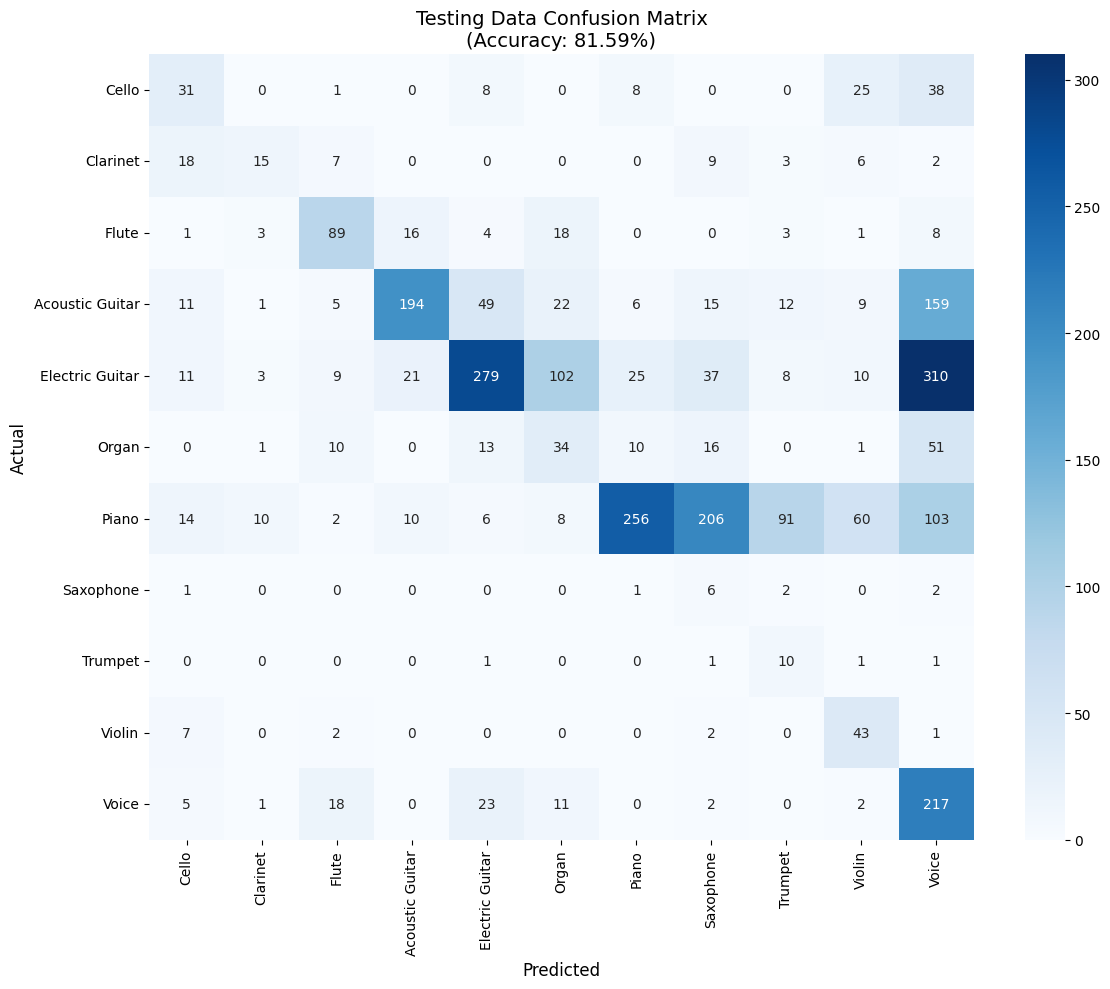

In [23]:
# CLASSIFICATION REPORT VÀ CONFUSION MATRIX CHO TESTING DATA
# Encode labels
test_true_encoded = label_encoder_seg.transform(test_true)
test_pred_encoded = label_encoder_seg.transform(test_preds)

# Classification Report
print("\n" + "="*60)
print("CLASSIFICATION REPORT - TESTING DATA")
print("="*60)
report_test = classification_report(
    test_true_encoded, test_pred_encoded,
    target_names=[INSTRUMENT_MAP.get(x, x) for x in label_encoder_seg.classes_],
    output_dict=True
)
print(classification_report(
    test_true_encoded, test_pred_encoded,
    target_names=[INSTRUMENT_MAP.get(x, x) for x in label_encoder_seg.classes_]
))

# Confusion Matrix
plt.figure(figsize=(12, 10))
cm_test = confusion_matrix(test_true_encoded, test_pred_encoded)
sns.heatmap(
    cm_test, annot=True, fmt='d', cmap='Blues',
    xticklabels=[INSTRUMENT_MAP.get(x, x) for x in label_encoder_seg.classes_],
    yticklabels=[INSTRUMENT_MAP.get(x, x) for x in label_encoder_seg.classes_]
)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title(f'Testing Data Confusion Matrix\n(Accuracy: {test_accuracy*100:.2f}%)', fontsize=14)
plt.tight_layout()
plt.show()


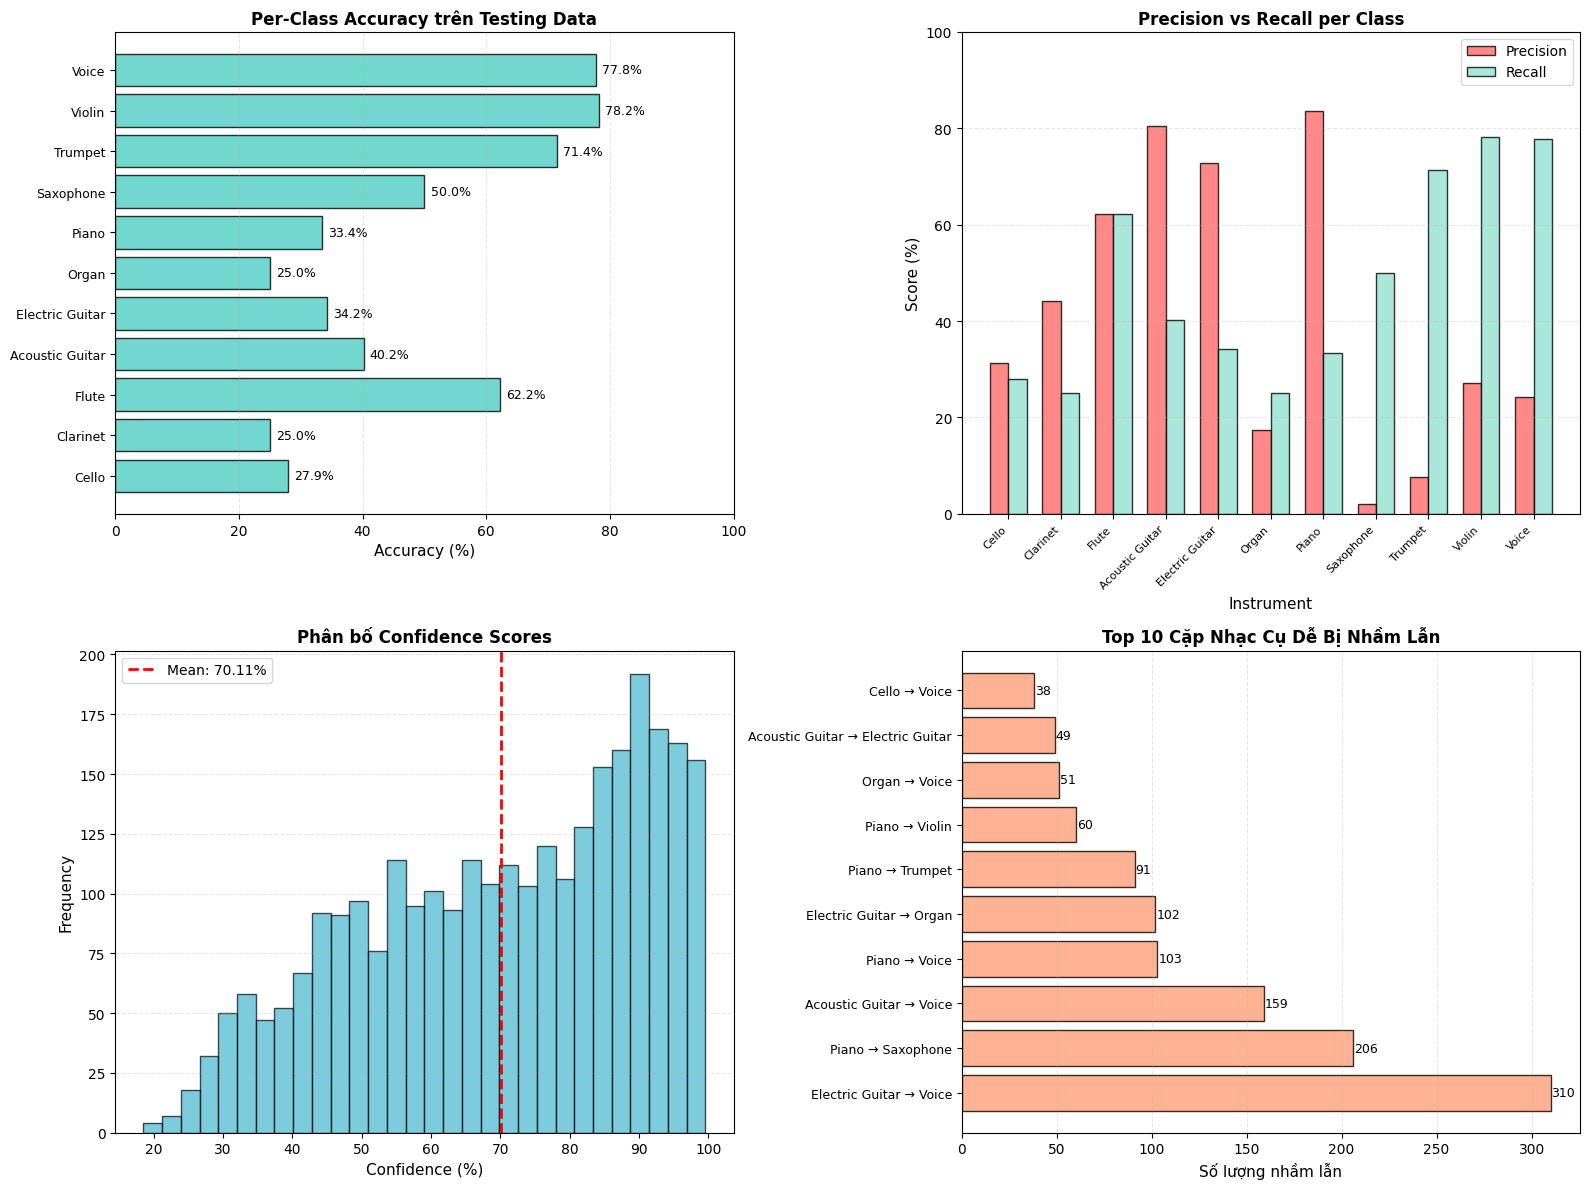


📊 Tổng hợp:
   - Average Confidence: 70.11%
   - Min Confidence: 18.51%
   - Max Confidence: 99.59%
   - Std Confidence: 20.24%


In [ ]:
# BIỂU ĐỒ PER-CLASS ACCURACY VÀ METRICS
# Tính per-class accuracy từ confusion matrix
class_names = [INSTRUMENT_MAP.get(x, x) for x in label_encoder_seg.classes_]
per_class_accuracy = []
per_class_precision = []
per_class_recall = []

for i in range(len(class_names)):
    # Accuracy cho class i = TP / (TP + FN)
    tp = cm_test[i, i]
    fn = cm_test[i, :].sum() - tp

    accuracy_i = tp / (tp + fn) if (tp + fn) > 0 else 0
    precision_i = report_test[class_names[i]]['precision']
    recall_i = report_test[class_names[i]]['recall']

    per_class_accuracy.append(accuracy_i)
    per_class_precision.append(precision_i)
    per_class_recall.append(recall_i)

# Tạo biểu đồ
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Per-class Accuracy
x_pos = np.arange(len(class_names))
axes[0, 0].barh(x_pos, [acc*100 for acc in per_class_accuracy], color='#4ECDC4', alpha=0.8, edgecolor='black')
axes[0, 0].set_yticks(x_pos)
axes[0, 0].set_yticklabels(class_names, fontsize=9)
axes[0, 0].set_xlabel('Accuracy (%)', fontsize=11)
axes[0, 0].set_title('Per-Class Accuracy trên Testing Data', fontsize=12, fontweight='bold')
axes[0, 0].set_xlim(0, 100)
axes[0, 0].grid(axis='x', alpha=0.3, linestyle='--')
# Thêm giá trị
for i, acc in enumerate(per_class_accuracy):
    axes[0, 0].annotate(f'{acc*100:.1f}%', xy=(acc*100 + 1, i), va='center', fontsize=9)

# 2. Precision vs Recall
x = np.arange(len(class_names))
width = 0.35
axes[0, 1].bar(x - width/2, [p*100 for p in per_class_precision], width, label='Precision',
               color='#FF6B6B', alpha=0.8, edgecolor='black')
axes[0, 1].bar(x + width/2, [r*100 for r in per_class_recall], width, label='Recall',
               color='#95E1D3', alpha=0.8, edgecolor='black')
axes[0, 1].set_xlabel('Instrument', fontsize=11)
axes[0, 1].set_ylabel('Score (%)', fontsize=11)
axes[0, 1].set_title('Precision vs Recall per Class', fontsize=12, fontweight='bold')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(class_names, rotation=45, ha='right', fontsize=8)
axes[0, 1].legend(fontsize=10)
axes[0, 1].set_ylim(0, 100)
axes[0, 1].grid(axis='y', alpha=0.3, linestyle='--')

# 3. Confidence Distribution
axes[1, 0].hist([c*100 for c in test_confidences], bins=30, color='#45B7D1', alpha=0.7,
                edgecolor='black', linewidth=1)
axes[1, 0].axvline(np.mean(test_confidences)*100, color='red', linestyle='--', linewidth=2,
                  label=f'Mean: {np.mean(test_confidences)*100:.2f}%')
axes[1, 0].set_xlabel('Confidence (%)', fontsize=11)
axes[1, 0].set_ylabel('Frequency', fontsize=11)
axes[1, 0].set_title('Phân bố Confidence Scores', fontsize=12, fontweight='bold')
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(axis='y', alpha=0.3, linestyle='--')

# 4. Top Confusion Pairs (các cặp nhạc cụ dễ bị nhầm lẫn nhất)
confusion_pairs = []
for i in range(len(class_names)):
    for j in range(len(class_names)):
        if i != j and cm_test[i, j] > 0:
            confusion_pairs.append({
                'actual': class_names[i],
                'predicted': class_names[j],
                'count': cm_test[i, j]
            })

confusion_pairs = sorted(confusion_pairs, key=lambda x: x['count'], reverse=True)[:10]
if confusion_pairs:
    pairs_labels = [f"{p['actual']} → {p['predicted']}" for p in confusion_pairs]
    pairs_counts = [p['count'] for p in confusion_pairs]

    axes[1, 1].barh(range(len(pairs_labels)), pairs_counts, color='#FFA07A', alpha=0.8, edgecolor='black')
    axes[1, 1].set_yticks(range(len(pairs_labels)))
    axes[1, 1].set_yticklabels(pairs_labels, fontsize=9)
    axes[1, 1].set_xlabel('Số lượng nhầm lẫn', fontsize=11)
    axes[1, 1].set_title('Top 10 Cặp Nhạc Cụ Dễ Bị Nhầm Lẫn', fontsize=12, fontweight='bold')
    axes[1, 1].grid(axis='x', alpha=0.3, linestyle='--')
    # Thêm giá trị
    for i, count in enumerate(pairs_counts):
        axes[1, 1].annotate(f'{count}', xy=(count + 0.5, i), va='center', fontsize=9)

plt.tight_layout()
plt.show()

print(f"\n Tổng hợp:")
print(f"   - Average Confidence: {np.mean(test_confidences)*100:.2f}%")
print(f"   - Min Confidence: {np.min(test_confidences)*100:.2f}%")
print(f"   - Max Confidence: {np.max(test_confidences)*100:.2f}%")
print(f"   - Std Confidence: {np.std(test_confidences)*100:.2f}%")


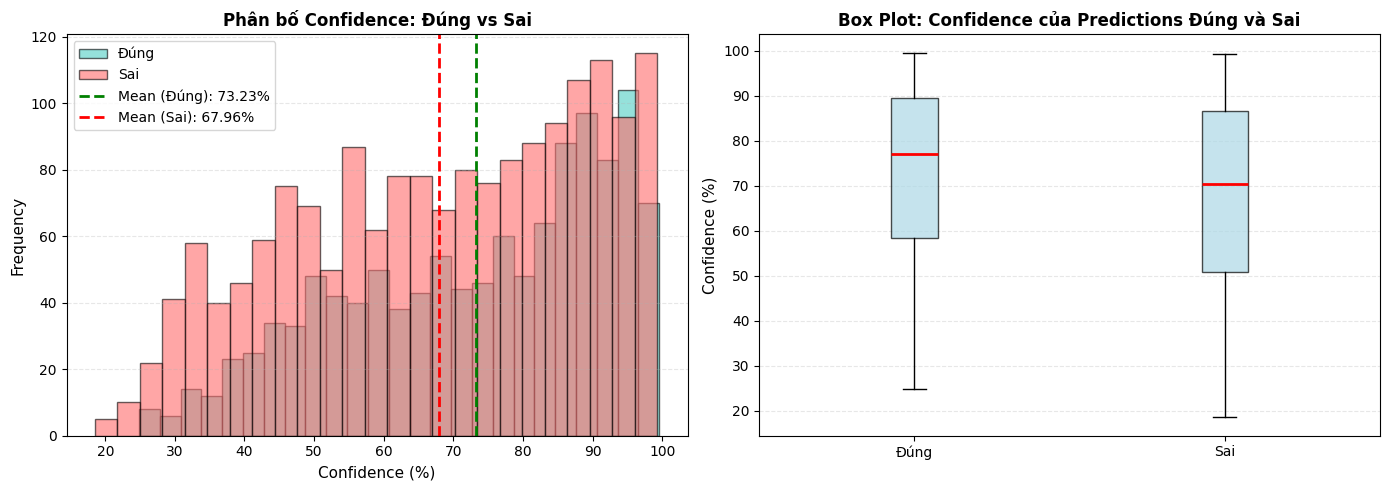


📊 Thống kê Confidence:
   - Đúng: Mean=73.23%, Median=77.16%
   - Sai: Mean=67.96%, Median=70.30%
   - Chênh lệch: 5.27%


In [ ]:
# BIỂU ĐỒ SO SÁNH CONFIDENCE GIỮA ĐÚNG VÀ SAI
# Phân loại confidence theo đúng/sai
correct_confidences = []
wrong_confidences = []

for i in range(len(test_preds)):
    if test_preds[i] == test_true[i]:
        correct_confidences.append(test_confidences[i] * 100)
    else:
        wrong_confidences.append(test_confidences[i] * 100)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Histogram so sánh confidence
axes[0].hist(correct_confidences, bins=25, alpha=0.6, label='Đúng', color='#4ECDC4',
            edgecolor='black', linewidth=1)
axes[0].hist(wrong_confidences, bins=25, alpha=0.6, label='Sai', color='#FF6B6B',
            edgecolor='black', linewidth=1)
axes[0].axvline(np.mean(correct_confidences), color='green', linestyle='--', linewidth=2,
               label=f'Mean (Đúng): {np.mean(correct_confidences):.2f}%')
axes[0].axvline(np.mean(wrong_confidences), color='red', linestyle='--', linewidth=2,
               label=f'Mean (Sai): {np.mean(wrong_confidences):.2f}%')
axes[0].set_xlabel('Confidence (%)', fontsize=11)
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].set_title('Phân bố Confidence: Đúng vs Sai', fontsize=12, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(axis='y', alpha=0.3, linestyle='--')

# 2. Box plot so sánh
data_to_plot = [correct_confidences, wrong_confidences]
bp = axes[1].boxplot(data_to_plot, labels=['Đúng', 'Sai'], patch_artist=True,
                    boxprops=dict(facecolor='lightblue', alpha=0.7),
                    medianprops=dict(color='red', linewidth=2))
axes[1].set_ylabel('Confidence (%)', fontsize=11)
axes[1].set_title('Box Plot: Confidence của Predictions Đúng và Sai', fontsize=12, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

print(f"\n Thống kê Confidence:")
print(f"   - Đúng: Mean={np.mean(correct_confidences):.2f}%, Median={np.median(correct_confidences):.2f}%")
print(f"   - Sai: Mean={np.mean(wrong_confidences):.2f}%, Median={np.median(wrong_confidences):.2f}%")
print(f"   - Chênh lệch: {np.mean(correct_confidences) - np.mean(wrong_confidences):.2f}%")


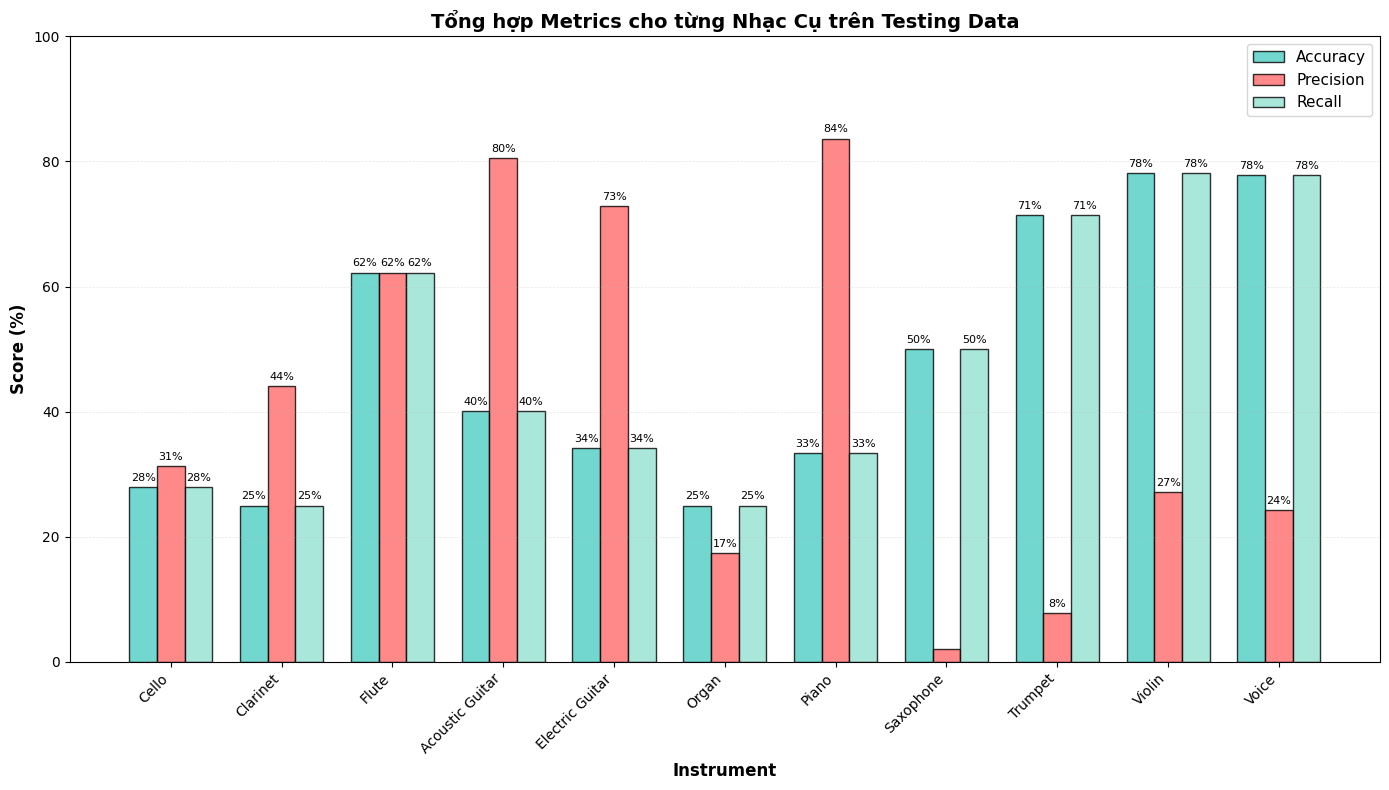


BẢNG TỔNG HỢP METRICS CHO TỪNG NHẠC CỤ
Nhạc Cụ              Accuracy     Precision    Recall       F1-Score    
--------------------------------------------------------------------------------
Cello                     27.93%       31.31%       27.93%       29.52%
Clarinet                  25.00%       44.12%       25.00%       31.91%
Flute                     62.24%       62.24%       62.24%       62.24%
Acoustic Guitar           40.17%       80.50%       40.17%       53.59%
Electric Guitar           34.23%       72.85%       34.23%       46.58%
Organ                     25.00%       17.44%       25.00%       20.54%
Piano                     33.42%       83.66%       33.42%       47.76%
Saxophone                 50.00%        2.04%       50.00%        3.92%
Trumpet                   71.43%        7.75%       71.43%       13.99%
Violin                    78.18%       27.22%       78.18%       40.38%
Voice                     77.78%       24.33%       77.78%       37.06%


In [27]:
# BIỂU ĐỒ TỔNG HỢP METRICS
# Tính F1-score cho mỗi class
per_class_f1 = []
for i, name in enumerate(class_names):
    f1 = report_test[name]['f1-score']
    per_class_f1.append(f1)

# Tạo biểu đồ radar chart style (bar chart với nhiều metrics)
fig, ax = plt.subplots(figsize=(14, 8))

x = np.arange(len(class_names))
width = 0.25

bars1 = ax.bar(x - width, [acc*100 for acc in per_class_accuracy], width,
               label='Accuracy', color='#4ECDC4', alpha=0.8, edgecolor='black')
bars2 = ax.bar(x, [p*100 for p in per_class_precision], width,
               label='Precision', color='#FF6B6B', alpha=0.8, edgecolor='black')
bars3 = ax.bar(x + width, [r*100 for r in per_class_recall], width,
               label='Recall', color='#95E1D3', alpha=0.8, edgecolor='black')

ax.set_xlabel('Instrument', fontsize=12, fontweight='bold')
ax.set_ylabel('Score (%)', fontsize=12, fontweight='bold')
ax.set_title('Tổng hợp Metrics cho từng Nhạc Cụ trên Testing Data', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(class_names, rotation=45, ha='right', fontsize=10)
ax.legend(fontsize=11, loc='upper right')
ax.set_ylim(0, 100)
ax.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.5)

# Thêm giá trị trên các bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        if height > 5:  # Chỉ hiển thị nếu đủ lớn
            ax.annotate(f'{height:.0f}%',
                       xy=(bar.get_x() + bar.get_width() / 2, height),
                       xytext=(0, 3),
                       textcoords="offset points",
                       ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

# Tạo bảng tổng hợp
print("\n" + "="*80)
print("BẢNG TỔNG HỢP METRICS CHO TỪNG NHẠC CỤ")
print("="*80)
print(f"{'Nhạc Cụ':<20} {'Accuracy':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
print("-"*80)
for i, name in enumerate(class_names):
    print(f"{name:<20} {per_class_accuracy[i]*100:>10.2f}%  {per_class_precision[i]*100:>10.2f}%  "
          f"{per_class_recall[i]*100:>10.2f}%  {per_class_f1[i]*100:>10.2f}%")
print("="*80)
